In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import rioxarray as rioxr
import geopandas as gpd

import warnings

import planetary_computer as pc

import gc # garbage collector

import dask
import dask_gateway
import dask.array as da
from dask_ml.wrappers import ParallelPostFit  # wrapper so that model predicts using dask

# custom modules
#import data_sampling_workflow.sample_rasters as sr
#import data_sampling_workflow.utility as ut
import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe


In [ ]:
t_alpha = time.time()

## Import & prepare train/test sets

In [6]:
# select features from r (Red band) to avg_lidar // excludes geometry, aoi, naip_id, polygon)id and iceplant features
X_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'r':'avg_lidar']

# select iceplant feature column
y_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'iceplant'] 

# remove 2012 and 2014 since these do not have LIDAR data of their own.
X_train = X_train.loc[X_train.year != 2012]
X_train = X_train.loc[X_train.year != 2014]

y_train = y_train.iloc[X_train.index]

In [8]:
# select features from r (Red band) to avg_lidar // excludes geometry, aoi, naip_id, polygon)id and iceplant features
X_test = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','test_set.csv')).loc[:,'r':'avg_lidar']

# select iceplant feature column
y_test = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','test_set.csv')).loc[:,'iceplant'] 

# remove 2012 and 2014 since these do not have LIDAR data of their own.
X_test = X_test.loc[X_test.year != 2012]
X_test = X_test.loc[X_test.year != 2014]

y_test = y_test.iloc[X_test.index]

In [ ]:
# # -- CHECKPOINT -- (uncomment if needed)

# # verify that train set only has data for 2016, 2018 and 2020
# print(X_train.year.unique())

# # verify that X_train and y_train have data for same points
# print(X_train.index)
# print(y_train.index)

In [10]:
mpe.iceplant_proportions(np.array(y_test))

no-iceplant:iceplant ratio     1.6 :1
          counts  percentage
iceplant                    
0          59816       61.72
1          37095       38.28



## Train model

In [11]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0), 'seconds')

time to train:  25.086349487304688 seconds


In [12]:
predictions = rfc.predict(X_test)
mpe.print_threshold_metrics(y_test, predictions)


true negatives: 59609     false positives: 207
false negatives: 291     true positives: 36804

sensitivity (TP/P): 99.22 %
specificity (TN/N): 99.65 %
G-mean:  0.99

precision (TP/(TP+FP)): 99.44 %

MCC:  0.9891217256602535

F1-measure:  0.99328
F0.5-measure (min false positives):  0.99396
F2-measure (min false negatives)  :  0.9926

accuracy: 99.49 %



In [13]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [18]:
X_test.columns.to_list()

['r',
 'g',
 'b',
 'nir',
 'ndvi',
 'year',
 'month',
 'day_in_year',
 'lidar',
 'max_lidar',
 'min_lidar',
 'min_max_diff',
 'avg_lidar']

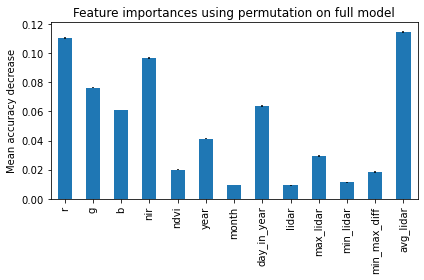

In [19]:
forest_importances = pd.Series(result.importances_mean, index=X_test.columns.to_list())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
del X_train, y_train
gc.collect()

# Select NAIP scene and LIDAR year
All the following code needs to be adapted to the new distribution of functions in utility.py and sample_rasters.py

In [ ]:
# gaviota_itemids = ['ca_m_3412039_nw_10_060_20200522',
# 'ca_m_3412039_nw_10_060_20180724_20190209',
# 'ca_m_3412039_nw_10_.6_20160616_20161004',
# 'ca_m_3412039_nw_10_1_20140603_20141030',
# 'ca_m_3412039_nw_10_1_20120518_20120730']

In [ ]:
campus_itemids = ['ca_m_3411934_sw_11_060_20200521',
                  'ca_m_3411934_sw_11_060_20180722_20190209',
                  'ca_m_3411934_sw_11_.6_20160713_20161004']

In [ ]:
# **************************************************************
# ********* SPECIFY ITEMID AND LIDAR YEAR TO MATCH HERE ********

itemid = campus_itemids[2] # NAIP scene over Conception Point
lidar_year = 2016
save_raster = True
filename = 'LIDAR+NAIP_campus_'+str(lidar_year)+'_predictions.tif'

# **************************************************************
# **************************************************************

# Open NAIP scene for classification

In [ ]:
naip_item =ipf.get_item_from_id(itemid)
href = pc.sign(naip_item.assets["image"].href)
 
# rioxarray of complete naip scene
naip_scene = rioxr.open_rasterio(rasterio.open(href))

# Prepare LIDAR data for sampling

In [ ]:
t0 = time.time()
# Create auxiliary LIDAR files to sample from

fp = sr.path_to_lidar(lidar_year)
lidar_reader = rasterio.open(fp)
lsf.save_min_max_rasters(lidar_reader, os.getcwd()+'/temp',lidar_year)
lsf.save_avg_rasters(lidar_reader, os.getcwd()+'/temp',lidar_year)

print('time to make auxiliary rasters: ', (time.time()-t0), 'seconds')

In [ ]:
# Resample lidar layers to match NAIP scene resolution and extent

lidar_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_mins_'+str(lidar_year)+'.tif')
mins_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_maxs_'+str(lidar_year)+'.tif')
maxs_match = lsf.open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_avgs_'+str(lidar_year)+'.tif')
avg_match = lsf.open_and_match(fp, naip_scene)

In [ ]:
# Assemble LIDAR layers into dataframe 
t0 = time.time()

df_lidar = pd.DataFrame()
df_lidar['lidar'] = lidar_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['max_lidar'] = maxs_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_lidar'] = mins_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_max_diff'] = df_lidar.max_lidar - df_lidar.min_lidar
df_lidar['avg_lidar'] = avg_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])

print('time to assemble dataframe: ', (time.time()-t0), 'seconds')

In [ ]:
# clear memory
del avg_match, mins_match, maxs_match, lidar_match
gc.collect()

In [ ]:
# Delete auxiliary LIDAR rasters in temp folder
lidar_fps = []
for tag in ['maxs_', 'mins_', 'avgs_']:
    lidar_fps.append(os.path.join(os.getcwd(),
                                  'temp',
                                  'lidar_'+tag+ str(lidar_year)+'.tif'))
for fp in lidar_fps:
    os.remove(fp)

In [ ]:
# lidar_reader.height
# lidar_reader.width

# Select points to be classified using NDVI threshold

In [ ]:
# select pixels above ndvi threshold
veg = ipf.features_over_aoi(naip_item, 
                           naip_scene.to_numpy(), 
                           thresh=0.05)

print('time to select above ndvi thresh: ', (time.time()-t0), 'seconds')
veg

# Sample and add LIDAR to vegetation pixels

In [ ]:
# select same indices as vegetation
t0 = time.time()

df_lidar_veg = df_lidar.iloc[veg.index]

print('time to select lidar corresponding to veg: ', (time.time()-t0), 'seconds')
df_lidar_veg

In [ ]:
# add LIDAR features to vegetation dataframe

# FEATURES MUST BE IN THIS ORDER TO MATCH THE MODEL:
# ['r', 'g', 'b', 'nir', 'ndvi', 
#  'year', 'month', 'day_in_year',
#  'lidar', 'max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar'])

scene_features = pd.concat([veg,df_lidar_veg],axis=1)
scene_features.head(2)

In [ ]:
# clear memory
del veg, df_lidar, df_lidar_veg
gc.collect()

# Make dask data array of pixel values from NAIP scene raster

In [ ]:
da_pixels = da.from_array(scene_features.to_numpy(), chunks=728802)
da_pixels

# Initialize Dask Cluster

In [ ]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(30)
client

# Predict using dask

In [ ]:
# initialize
predictions = rfc.predict(da_pixels)
predictions

In [ ]:
# compute predictions
t0 = time.time()

preds = predictions.compute()
print('time to predict: ', time.time()-t0)

# Reassemble predictions into image

In [ ]:
t0 = time.time()
preds_image = ipf.preds_to_image_3labels(naip_scene.shape[1], naip_scene.shape[2], 
                                     scene_features.index,
                                     preds)
print('indices to image time: ', time.time()-t0)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("LIDAR + SPECTRAL PREDICTIONS : "+str(lidar_year)+ " campus point NAIP scene")
ax.imshow(preds_image)
plt.show()

In [ ]:
# save if necessary

if save_raster == True:
    with rasterio.open(
        os.path.join(os.getcwd(),'temp',filename),  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = preds_image.shape[0], 
        width = preds_image.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = naip_scene.rio.crs,
        transform = naip_scene.rio.transform(),
    ) as dst:
        dst.write(preds_image.astype(rasterio.uint8), 1)

In [ ]:
# clean memory
del naip_scene, scene_features
del preds_image, predictions
gc.collect()

In [ ]:
print('total time:', time.time() - t_alpha )